### 노래의 특징|(댄스 가능성, 라이브성, 음량, 에너지)을 바탕으로 노래가 히트할지 안할지 예측한다.

- 데이터 전처리, 머신러닝 |(모델 선택), 시각화
- 회귀
- 앙상블
- GridSearch | 하이퍼파라미터 자동 최적화

### 데이터셋 
kaggle 데이터셋|

### 진행 목차
1. 데이터 불러오기
2. 데이터 분석|(EDA)
3. 데이터 전처리
4. 인기 예측 회귀모델
5. 성능 분석
6. 회귀 모델 고도화

In [64]:
import matplotlib as mpl
mpl.rcdefaults()

In [65]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/song-popularity-dataset")

print("Path to dataset files", path)

Path to dataset files C:\Users\Playdata\.cache\kagglehub\datasets\yasserh\song-popularity-dataset\versions\1


In [66]:
import matplotlib.font_manager as fm
font_path = r"C:\Users\Playdata\AppData\Local\Microsoft\Windows\Fonts\NanumGothic-Regular.ttf"
print(fm.FontProperties(fname=font_path).get_name())

NanumGothic


In [67]:
# 노래 데이터 불러오기
df = pd.read_csv("data/song_data.csv",encoding='utf-8')

target = 'song_popularity' # 타겟 변수|(노래 인기도)


### 종속변수
- song_popularity | 인기점수
### 특징 |(독립 변수)
|특성명|설명|범위/값|
|------|----|------|
|song_name | 트랙 제목 | -
|song_duration_ms | 노래길이  |(밀리초 단위)
|acousticness | 어쿠스틱 노래 가능성 |(0~1)
|danceablility | 노래에 춤추기 적합한 정도 |(0~0.99) 
|energy | 노래의 에너지 강도 |(0~1.0)
|instrumentalness | 노래에 보컬이 없을 가능성 |(0~1.0)
|key | 음악 키 |(0 = C, 11 = B, 0~11)
|liveness | 라이브 관객의 존재 추정 |(0.01~0.99)
|loudness | 라이브 관객의 존재 추정 |(-38.8~1.58)
|audio_mode | 조성 |(1:장조, 0:단조)
|speechiness | 발화된 단어가 존재할 가능성 |(0.0~0.94)
|tempo | 분당 박자 |(BPM)
|time_signature | 음악 한 마디의 박자 |(0~5)
|audio_valance | 트랙의 긍정성 또는 괘활함 |(0.0~0.98)

In [68]:
df.drop(["song_name"], axis=1, inplace=True) # song_name 열은 사용하지않아 삭제


In [69]:
features = [i for i in df.columns if i not in [target]] # 특성 필터링
original_df = df.copy(deep=True) # 데이터 원본 보존 깊은 복사

df.shape
print(f"이 데이터셋에는 {df.shape[1]}개의 특성과 {df.shape[0]}개의 샘플로 구성되어 있다.")


이 데이터셋에는 14개의 특성과 18835개의 샘플로 구성되어 있다.


### 탐색적 데이터 분석 (EDA)

In [70]:
df.info() # 누락된 데이터없다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [71]:
# 숫자형, 범주홍 특징 식별
nu = df[features].nunique().sort_values() # 각 특성별로 고유값(카테고리) 갯수 계산 후 결정
nf = [] # 숫자형 특성 리스트
cf = [] # 범주형 특성 리스트
nnf = [] # 숫자형 특성 갯수
ncf = [] # 범주형 특성 갯수

# 16개 이하의 값을 가진 특징은 범주형으로 간주한다. 
for i in range(df[features].shape[1]):
    if nu.values[i] <= 16:
        cf.append(nu.index[i])
    else:
        nf.append(nu.index[i])
print(f"이 데이터셋은 {len(nf)}개의 숫자형, {len(cf)}개의 범주형 특성을 가지고 있다.")
print(f"숫자형 특성 : {nf}")
print(f"범주형 특성 : {cf}")

이 데이터셋은 10개의 숫자형, 3개의 범주형 특성을 가지고 있다.
숫자형 특성 : ['danceability', 'energy', 'speechiness', 'audio_valence', 'liveness', 'acousticness', 'instrumentalness', 'loudness', 'song_duration_ms', 'tempo']
범주형 특성 : ['audio_mode', 'time_signature', 'key']


In [72]:
df['song_popularity']

0        73
1        66
2        76
3        74
4        56
         ..
18830    60
18831    60
18832    23
18833    55
18834    60
Name: song_popularity, Length: 18835, dtype: int64

In [73]:
df.isnull().sum()

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [74]:
df[nf].describe().T # 통계량을 행이아닌 컬럼으로 확인한다.

,count,mean,std,min,25%,50%,75%,max
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
speechiness,18835.0,0.102099,0.104378,0.000000,0.0378,0.055500,0.11900,0.941
audio_valence,18835.0,0.527967,0.244632,0.000000,0.3350,0.527000,0.72500,0.984
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
tempo,18835.0,121.073154,28.714456,0.000000,98.3680,120.013000,139.93100,242.318


C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\261398399.py:21: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\261398399.py:21: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\261398399.py:21: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\261398399.py:21: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\261398399.py:21: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\i

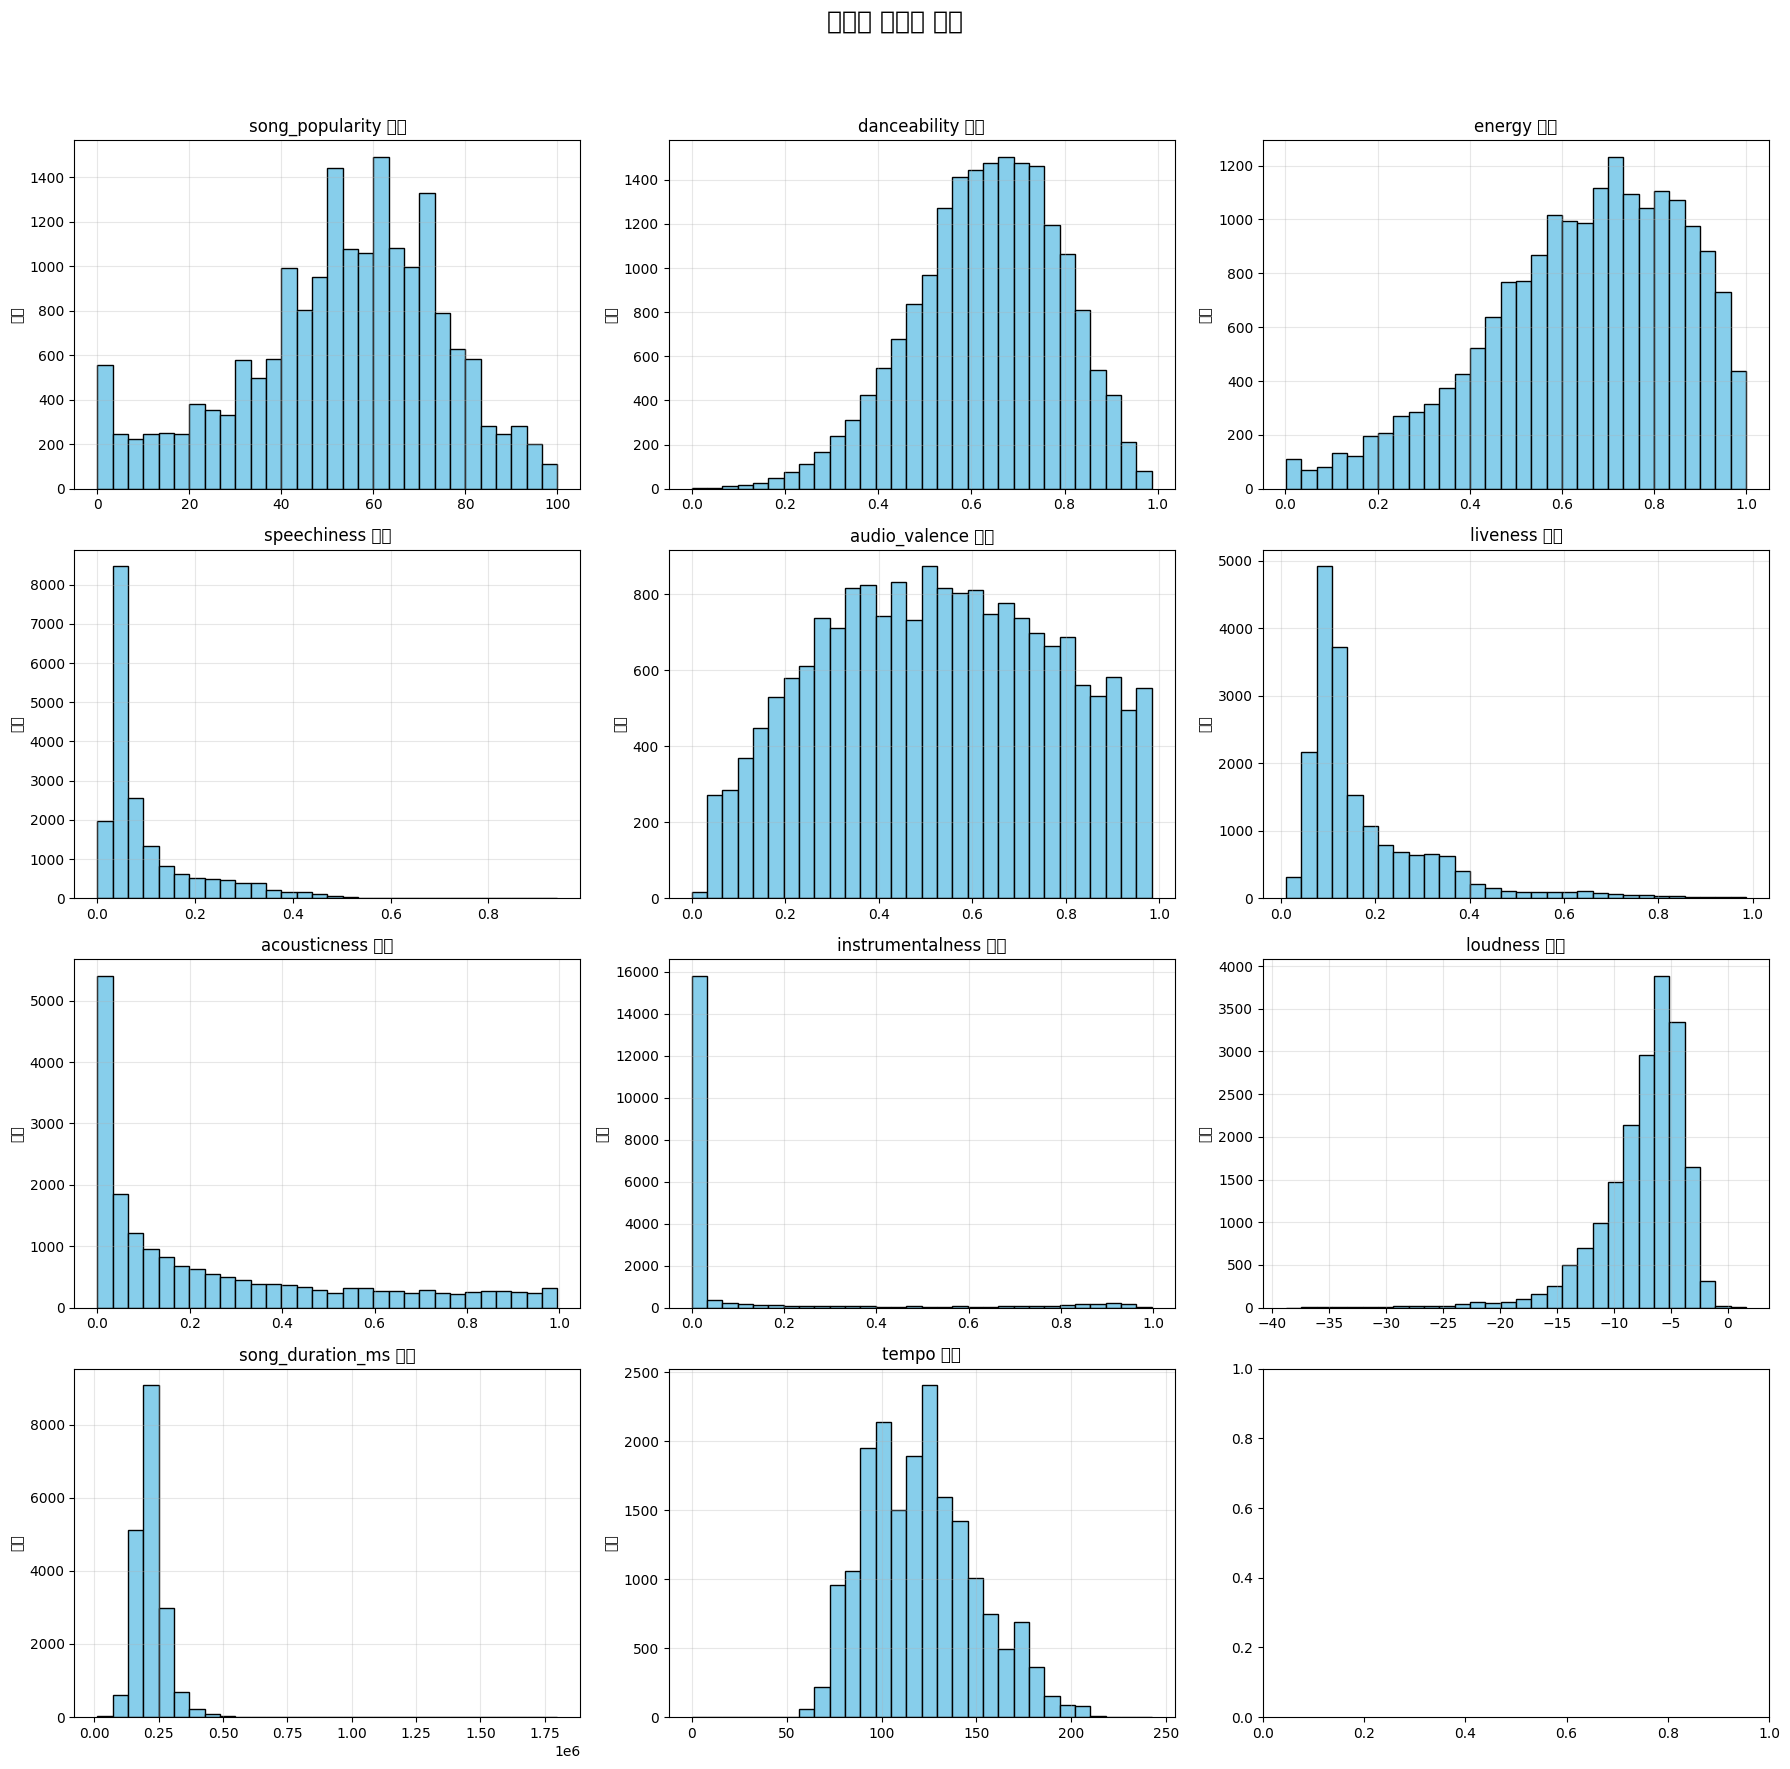

In [75]:
# 수치형 변수의 분포
columns = [target] + nf # 타겟(인기도)와 숫자형 특성들 리스트


fig, axes = plt.subplots(4, 3, figsize=(18, 18))    # 4행 3열의 서브플롯(그래프) 생성
for idx, col in enumerate(columns):
    row = idx // 3                                  # 몇번째 행에 그릴지 결정 (4번째 인덱스 : 1)
    col_idx = idx % 3                               # 몇번째 열에 그릴지 결정 (4번째 인덱스 : 1)
    axes[row][col_idx].hist(
                            df[col].dropna()        # 데이터는 해당 컬럼
                            , bins=30               # 구간은 30
                            , color='skyblue'       # 색 지정
                            , edgecolor='black'     # 테두리 색
                            )                       # 히스토그램
    
    axes[row][col_idx].set_title(f"{col} 분포")     
    axes[row][col_idx].set_ylabel("빈도")
    axes[row][col_idx].grid(alpha=0.3)              # 격자(그리드) 표시, 투명도 0.3
    
fig.suptitle("수치평 특성의 분포", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

<Axes: >

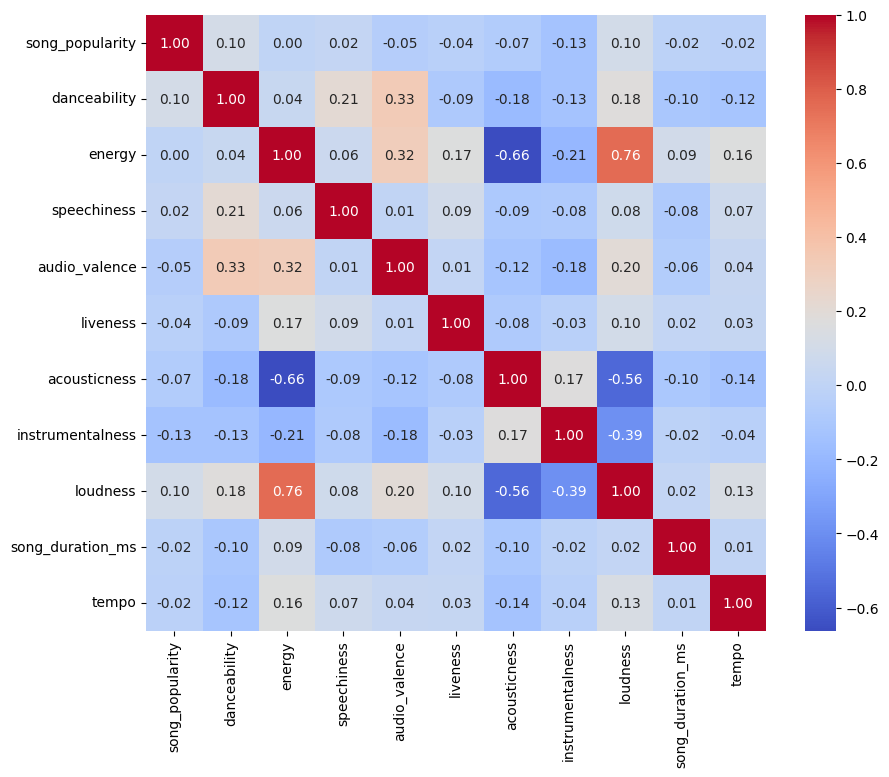

In [76]:
# 수치형 특성간 상관관계 매트릭스

plt.figure(figsize=(10,8))
corr_matrix = df[[target]+nf].corr(numeric_only=True) # 수치형 변수들만 상관관계 계산

sns.heatmap(
    corr_matrix,    # 상관관계 데이터
    annot=True,     # 내부 값 표시
    fmt = '.2f',    # 값 형태(소수점 2자리)
    cmap = 'coolwarm'
)

수치형 변수들 확인 결과 목표 변수인 song_popularity 와 매우 낮은 상관관계를 보이는 것을 확인. 

일부 변수간의 상관관계가 오히려 더 있어 보임. (예: energy - loudness)

=> 다중공선성이 존재할 수 있다. 
만약 컬럼간의 중복성이 있다면 하나의 컬럼을 삭제하는것도 고려해봐야 한다. 

다중공선성(특정 변수들간의 중복성) 확인하기 위해 VIF(Variance Inflation Factor)를 확인한다.
VIF 5를 초과하면 높은 다중공선성이 있고, 강한 상관관계를 가짐을 의미한다. 

In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # 상수항 추가시에 사용

checking_columns = ['instrumentalness', 'energy','loudness','acousticness','audio_valence'] # VIF 확인할 변수 목록

vif_df = df[checking_columns].copy()
vif_df = vif_df.dropna()

vif_data = add_constant(vif_df)
# vif_data

vif = pd.DataFrame()
vif['feature'] = vif_data.columns

vif['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])] # 각 변수별 VIF 계산

vif = vif[vif['feature'] != 'const'] # 상수항 제외
vif

,feature,VIF
1,instrumentalness,1.237084
2,energy,3.252280
3,loudness,2.751105
4,acousticness,1.834072
5,audio_valence,1.160981


1에 가까운 2개의 컬럼은 중복성이 매우낮다.

그 외 3개의 컬럼은 어느정도 중복성이 있어 보인다. 그러나 5를 넘지 않았기 때문에 삭제를 고려할 정도의 수준은 아니다.


C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\3929489149.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='audio_mode',y='song_popularity',data=df, palette="Set2")


Text(0, 0.5, '노래 인기도')

c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing

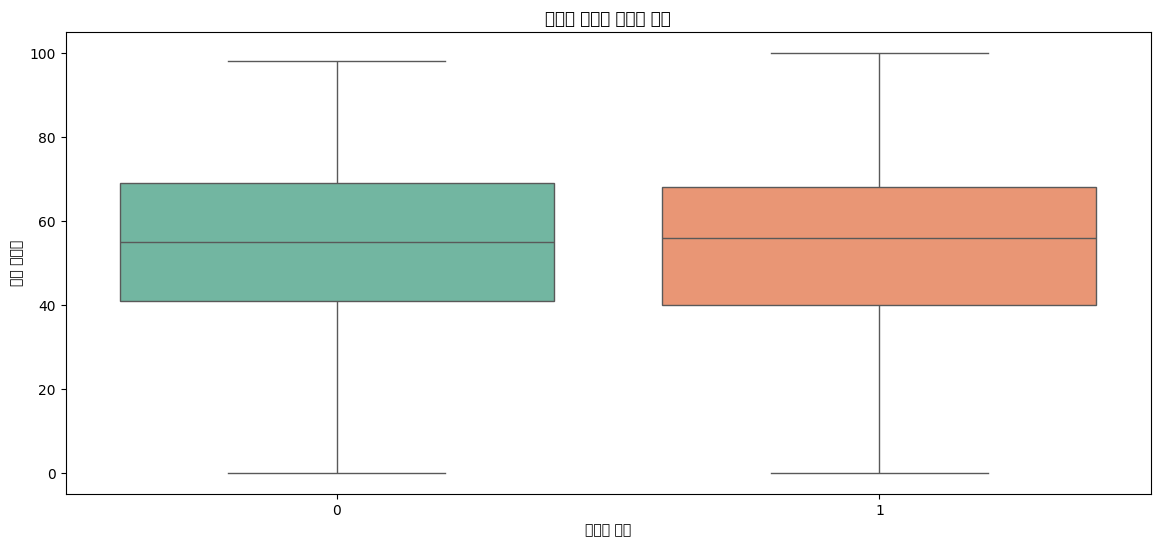

In [78]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14,6))
sns.boxplot(x='audio_mode',y='song_popularity',data=df, palette="Set2")
plt.title("오디오 모드별 인기도 분포")
plt.xlabel('오디오 모드')
plt.ylabel('노래 인기도')

C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2589773011.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='key',y='song_popularity',data=df, palette="Set2")


Text(0, 0.5, '노래 인기도')

c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing

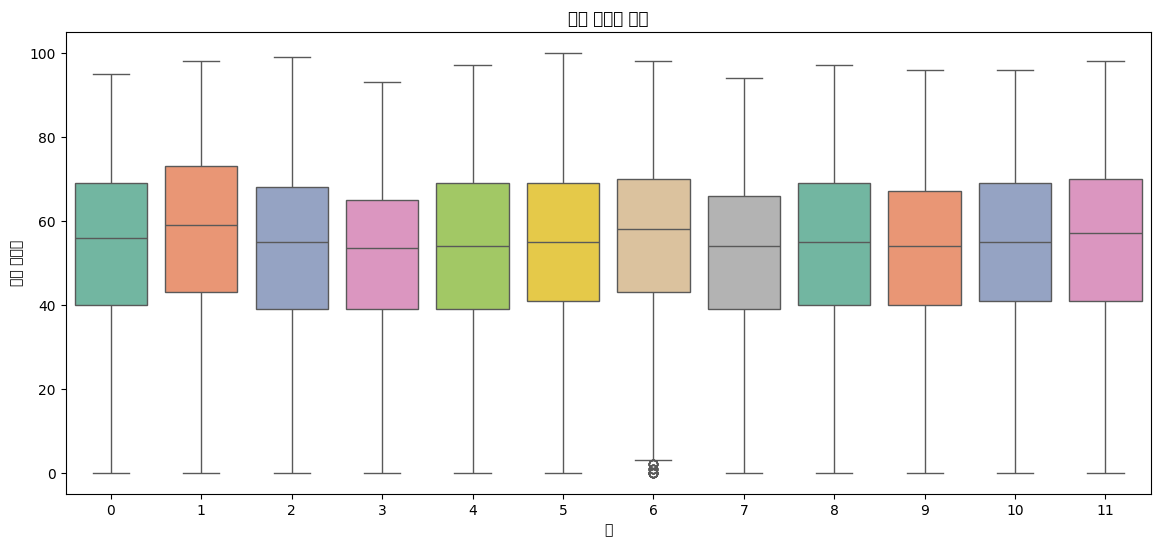

In [79]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14,6))
sns.boxplot(x='key',y='song_popularity',data=df, palette="Set2")
plt.title("키별 인기도 분포")
plt.xlabel('키')
plt.ylabel('노래 인기도')

C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\189764687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_signature',y='song_popularity',data=df, palette="Set2")


Text(0, 0.5, '노래 인기도')

c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing

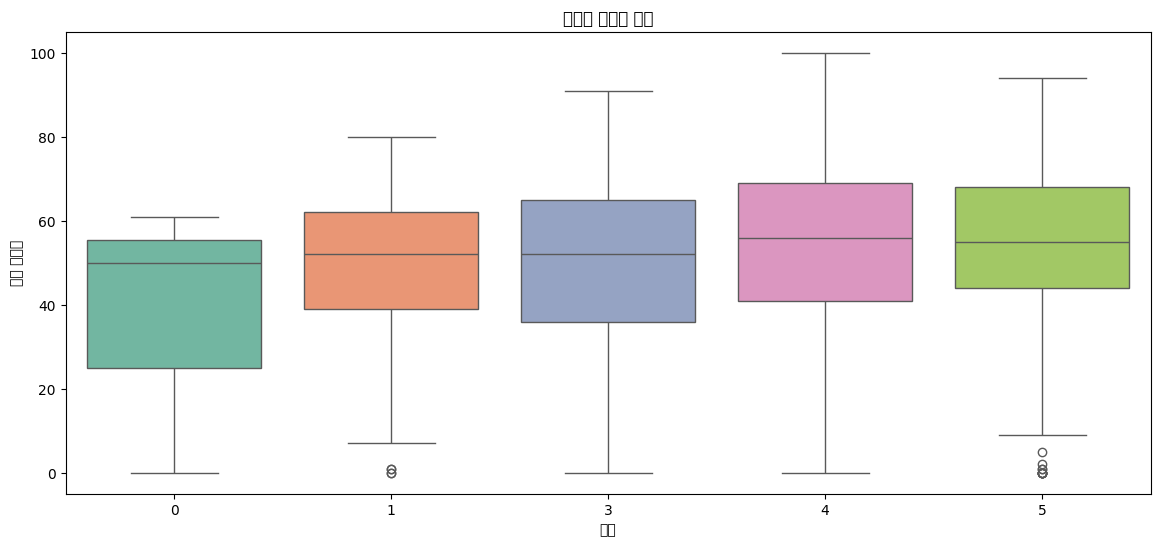

In [80]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14,6))
sns.boxplot(x='time_signature',y='song_popularity',data=df, palette="Set2")
plt.title("시간별 인기도 분포")
plt.xlabel('시간')
plt.ylabel('노래 인기도')

범주형 변수들은 개별적으로는 뚜렷한 패턴은 없었다.

### 데이터 전처리

- 결측값 처리 : 결측값은 없었다. 
- 이상치 : IQR 방식으로 탐지하여 제거한다. 
- 특성 정규화 : 왜도가 있는 수치형 변수(speechiness, liveness, acousticness, instrumentalness)에 대해서 정규화 적용해서 정규 분포에 가깝게 만들어준다. 
정규 분포에 가깝게 만들어준다. 
- 범주형 변수 인코딩


In [81]:
# 이상치 데이터 샘플링
df1 = df.copy()
features1 = nf + ['song_popularity'] # 숫자형 특성과 타겟 변수 포함
for i in features1:
    Q1 = df1[i].quantile(0.25)                  # 1사분위수 (25%)
    Q3 = df1[i].quantile(0.75)                  # 3사분위수 (75%)
    IQR = Q3 - Q1
    
    df1 = df1[df1[i] <= (Q3 + (1.5 * IQR))]     # 이상치 상한선(3사분위수 + 1.5 * IQR) 초과 샘플 제거
    df1 = df1[df1[i] >= (Q1 - (1.5 * IQR))]     # 이상치 상한선(1사분위수 - 1.5 * IQR) 초과 샘플 제거
    df1 = df1.reset_index(drop=True)            # 인덱스 재설정
    
print(f'이상치 제거 전 샘플 수 : {df.shape[0]}')
print(f'이상치 제거 후 샘플 수 : {df1.shape[0]}')
df = df1.copy()


이상치 제거 전 샘플 수 : 18835
이상치 제거 후 샘플 수 : 11183


정규화 : 왜도가 있는 컬럼들에 대해 np.log1p를 적용한다.

=> 정규분포를 따르는 가우시안 분포를 그린다.

In [82]:
skewed_columns =  ['speechiness', 'liveness', 'acousticness', 'instrumentalness'] # 왜도가 확인된 특성 리스트

from copy import deepcopy
df_log = deepcopy(df) # 원본 데이터 훼손 방지용 복사본 생성
df_log[skewed_columns] = df[skewed_columns].apply(np.log1p) # 해당 컬럼에 log1p(로그 변환) 적용


C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\857675632.py:17: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\857675632.py:17: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\857675632.py:17: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\857675632.py:17: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\857675632.py:17: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])
C:\Users\Playdata\AppData\Local\Temp\i

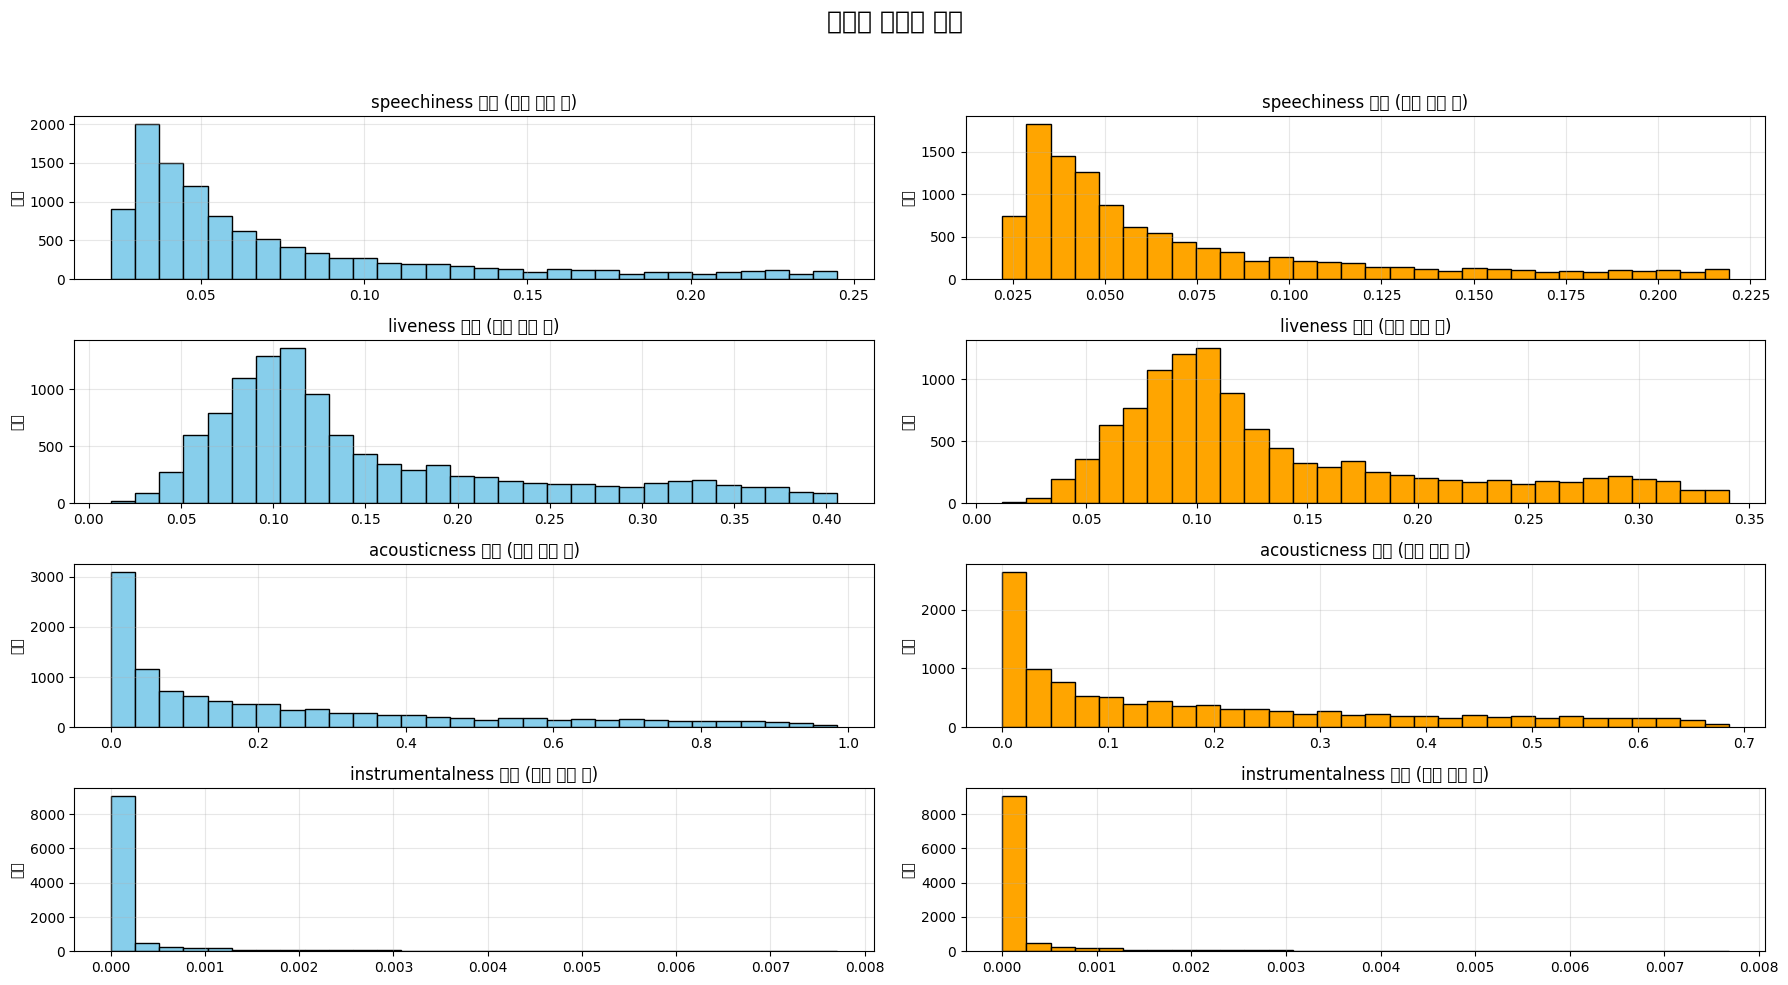

In [83]:
# 보정 전후로 분포 비교
fig, axes = plt.subplots(4,2, figsize=(18,10)) # 4행(각 컬럼) 2열(전/후) 서브플롯 생성

for idx, col in enumerate(skewed_columns):
    row = idx
    axes[row][0].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')     # 로그 변환 전 분포
    axes[row][0].set_title(f'{col} 분포 (로그 변환 전)')
    axes[row][0].set_ylabel('빈도')
    axes[row][0].grid(alpha=0.3)
    
    axes[row][1].hist(df_log[col].dropna(), bins=30, color='orange', edgecolor='black')     # 로그 변환 후 분포
    axes[row][1].set_title(f'{col} 분포 (로그 변환 후)')
    axes[row][1].set_ylabel('빈도')
    axes[row][1].grid(alpha=0.3)
    
plt.suptitle('수치형 특성의 분포', fontsize=18)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
    

log1p 적용 후 분포 완화
수치로 변환하여 확인

In [84]:
df[skewed_columns].skew() # 왜도 값 계산(0이면 완전 대칭, 0보다 크면 우측 왜도(양의 왜도), 0보다 작으면 좌측 왜도(음의왜도))


speechiness         1.552620
liveness            1.156883
acousticness        1.134955
instrumentalness    3.831057
dtype: float64

In [85]:
df_log[skewed_columns].skew()

speechiness         1.470770
liveness            1.044367
acousticness        0.894389
instrumentalness    3.826448
dtype: float64

In [86]:
df = df_log # 로그 변환된 데이터를 기존 데이터로 사용하겠다

노래 회귀 예측 모델 구현

In [87]:
# 선형 회귀 모델
from sklearn.linear_model import LinearRegression # 선형 회귀 모델
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # 회귀 성능 평가 지표
from sklearn.model_selection import train_test_split    # 데이터셋 분할 함수

X = df[features] # 입력변수(특성)
y = df[target] # 타겟 변수(인기도)

# 학습/테스트 데이터셋 분리 (80%:20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))



8946 2237 8946 2237


In [88]:
# LinearRegression 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)  # 모델 학습

y_pred_lr = lr_model.predict(X_test) # 테스트셋 예측
# 학습 데이터 평가 
print("Train MSE: ", mean_squared_error(y_train[:1000],lr_model.predict(X_train[:1000])))
print("Train MAE: ", mean_absolute_error(y_train[:1000],lr_model.predict(X_train[:1000])))
print("Train R2 Score: ", r2_score(y_train[:1000],lr_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE : ", mean_squared_error(y_test,y_pred_lr))  # 테스트셋 MSE
print("MAE : ", mean_absolute_error(y_test,y_pred_lr))  # 테스트셋 MAE
print("R2 SCORE : ", r2_score(y_test,y_pred_lr))  # 테스트셋 R2 SCORE

Train MSE:  431.63482714669885
Train MAE:  16.57721232458603
Train R2 Score:  0.06808225594698936

MSE :  439.34301511752426
MAE :  16.695875787455037
R2 SCORE :  0.05003437855473547


### 선형 회귀 모델로는 성능이 매우 뒤떨어짐을 확인하였습니다.

### 다른 모델을 사용해봐야겠다.

In [89]:
# 다항 회귀 모델 : n차 다항식을 사용하여 비선형 관계를 모델링하는 모델.
# 단점으로는 모델의 차수가 지나치게 높아지면 모델 복잡성이 커져 과적합 가능성이 있는 모델이다.

from sklearn.preprocessing import PolynomialFeatures

degree = 2 # 다항식 특성의 차수
poly = PolynomialFeatures(degree)               # 특성을 다항식 특성으로 변환
X_train_poly = poly.fit_transform(X_train)      # 학습 데이터 변환
X_test_poly = poly.transform(X_train)           # 테스트 데이터 변환

# 다항식 특성으로 모델 학습
poly_lr_model = LinearRegression()
poly_lr_model.fit(X_train, y_train)  # 모델 학습

poly_lr = poly_lr_model.predict(X_test)

# 학습 데이터 평가 
print("Train MSE: ", mean_squared_error(y_train[:1000],poly_lr_model.predict(X_train[:1000])))
print("Train MAE: ", mean_absolute_error(y_train[:1000],poly_lr_model.predict(X_train[:1000])))
print("Train R2 Score: ", r2_score(y_train[:1000],poly_lr_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE : ", mean_squared_error(y_test,poly_lr))  # 테스트셋 MSE
print("MAE : ", mean_absolute_error(y_test,poly_lr))  # 테스트셋 MAE
print("R2 SCORE : ", r2_score(y_test,poly_lr))  # 테스트셋 R2 SCORE


#코드...


Train MSE:  431.63482714669885
Train MAE:  16.57721232458603
Train R2 Score:  0.06808225594698936

MSE :  439.34301511752426
MAE :  16.695875787455037
R2 SCORE :  0.05003437855473547


### 선형 모델보다는 약간 나아진 모습은 있지만 성능은 낮다.

In [90]:
# random Forest 회귀 모델 : 여러개의 의사결정 나무를 결합해 비선형적이고 앙상블 기반의 학습을 제곤한다. 
# 앙상블 사용 -> 과적합에도 강하다.
from sklearn.ensemble import RandomForestRegressor # 랜덤 포레스트 회귀 모델

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train) # 학습 데이터로 모델 학습

# 예측
y_pred_rf = rf_model.predict(X_test)    # 테스트 데이터로 예측

print("Train MSE :", mean_squared_error(y_train[:1000],rf_model.predict(X_train[:1000])))
print("Train MAE :", mean_absolute_error(y_train[:1000],rf_model.predict(X_train[:1000])))
print("Train R2 Score :", r2_score(y_train[:1000],rf_model.predict(X_train[:1000])))

# 테스트셋 데이터 평가
print("MSE : ", mean_squared_error(y_test,y_pred_rf))  # 테스트셋 MSE
print("MAE : ", mean_absolute_error(y_test,y_pred_rf))  # 테스트셋 MAE
print("R2 SCORE : ", r2_score(y_test,y_pred_rf))  # 테스트셋 R2 SCORE


Train MSE : 43.10566981387936
Train MAE : 4.551614510493591
Train R2 Score : 0.9069330460788059
MSE :  274.77396523761075
MAE :  11.80355589517433
R2 SCORE :  0.4058723783873017


전 모델에 비해서 성능이 좋음, 절대적인 성능은 부족함

c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-

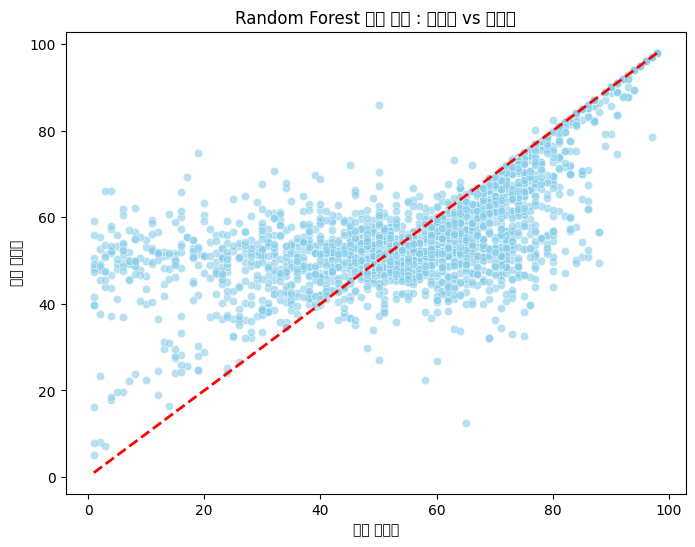

In [91]:
#성능 시각화 (실제값 vs 예측값)
plt.figure(figsize = (8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color = 'skyblue', alpha=0.6) # 산점도 : 실제값 vs 예측값
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2, label="완벽한 에측선") # 대각선
plt.xlabel("실제 인기도")
plt.ylabel("예측 인기도")
plt.title("Random Forest 회귀 모델 : 실제값 vs 예측값")
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2200673409.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="중요도", y="특성", data=feat_df.head(10), palette='viridis') # 상위 10개 특성 중요도 bar플롯
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2200673409.py:16: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2200673409.py:16: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2200673409.py:16: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14240\2200673409.py:16: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}

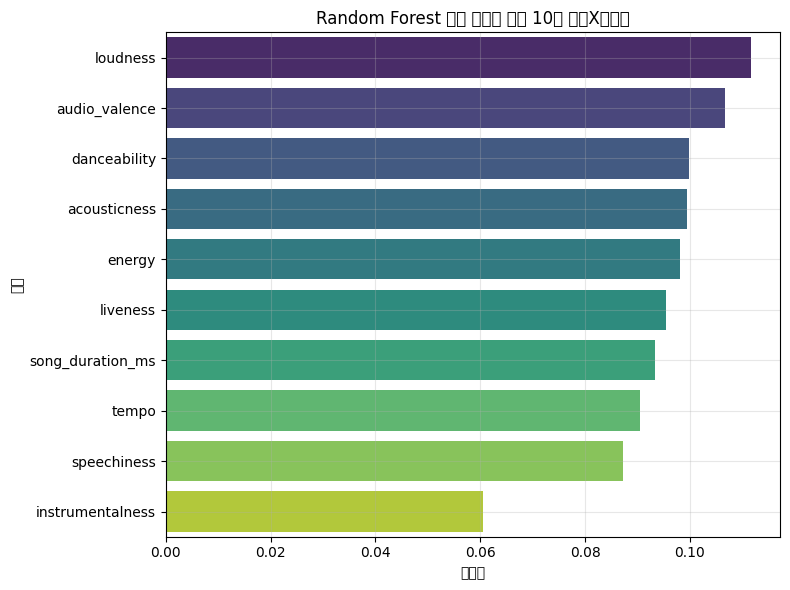

In [92]:
# Random Forest 모델이 예측할때 중요도 분석
importance = rf_model.feature_importances_ # 각 특성의 중요도 추출
features = X.columns # 특성명 리스트

feat_df = pd.DataFrame({"특성" : features, "중요도": importance}) # 데이터프레임 생성
feat_df.sort_values(by="중요도", ascending=False, inplace = True)  # 중요도 기준 내림차순
feat_df

#시각화
plt.figure(figsize = (8,6))
sns.barplot(x="중요도", y="특성", data=feat_df.head(10), palette='viridis') # 상위 10개 특성 중요도 bar플롯
plt.xlabel("중요도")
plt.ylabel("특성")
plt.title("Random Forest 회귀 모델의 상위 10개 특성X중요도")
plt.grid(alpha=0.3) # 격자
plt.tight_layout()
plt.show()

### 회귀 모델 고도화
GridSearchCV를 사용해서 Random Forest 모델을 고도화 하려고 한다. 
n_estimators : 숲을 구성할 트리의 갯수 (기본값 100)
max_depth : 각 트리의 최대 깊이 (기본값 None : 모든 리프 노드가 가장 순수해질 때까지 성장)
min_samples_split : 내부 노드를 분할하기 위해 필요한 최소 샘플 수 (기본값 : 2)

하이퍼파라미터 튜닝 도구는 GridSearchCV 말고도  Optuna도 있다.

In [93]:
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝 도구

param_grid = {
    'n_estimators':[100,200]        # 트리 갯수
    , 'max_depth':[None,10,20]      # 트리 최대 깊이
    , 'min_samples_split':[2,5]     # 내부 노드를 분할하기 위한 최소 샘플 수
}

# 5초 x 2 x 3 x 2 예상
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf,                                                     # 최적 파라미터를 뽑아낼 모델
    param_grid,                                             # 최적 파라미터를 테스트할 값
    cv = 5,                                                 # 5-fold 교차 검증  
    scoring = 'neg_mean_squared_error',                     # 성능 평가지포 : 평균제곱오차 MSE
    n_jobs = -1,                                            # 모든 CPU 사용(병렬)
    verbose = 2                                             # 진행사항 출력
)

grid_search.fit(X_train, y_train)                           # 하이퍼파라미터 튜닝(모델 학습)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is di

In [94]:
best_rf = grid_search.best_estimator_       # 최적의 하이퍼파라미터로 학습된 Random Forest 모델
print(f'최고의 설정값은? {grid_search.best_params_}')   # 파라미터 조합중 가장 성능이 좋은 조합 출력 


최고의 설정값은? {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


### 최고의 설정 값

- 'max_depth':None, 'min_samples_split': 2, 'n_estimators': 200
- => 이걸로 Random Forest 모델을 다시 학습을 시키고 결과를 확인한다. 

In [95]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42) # 테스트셋 예측
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# 학습 데이터
print("Train MSE :", mean_squared_error(y_train[:1000],rf_model.predict(X_train[:1000])))
print("Train MAE :", mean_absolute_error(y_train[:1000],rf_model.predict(X_train[:1000])))
print("Train R2 Score :", r2_score(y_train[:1000],rf_model.predict(X_train[:1000])))

# 테스트셋 데이터 평가
print("MSE : ", mean_squared_error(y_test,y_pred_rf))  # 테스트셋 MSE
print("MAE : ", mean_absolute_error(y_test,y_pred_rf))  # 테스트셋 MAE
print("R2 SCORE : ", r2_score(y_test,y_pred_rf))  # 테스트셋 R2 SCORE

Train MSE : 42.392727139473706
Train MAE : 4.53493405665862
Train R2 Score : 0.9084723192953886
MSE :  272.5474121507958
MAE :  11.785158677020554
R2 SCORE :  0.41068672347534474


R2 스코어 기준 0.40 > 0.41 로 소폭 상승

# 모델 변경 (Boosting 계열)
- SGBoost : 약한 모델에서부터 순차적으로 트리를 추가하는 방식의 그래디언트 부스팅
- LightGBM : 더 빠르고 효율적인 그래디언트 부스팅 알고리즘. 내부적으로 히스토그램 기반의 분할 방식과 리프 중심 트리 성장 전략을 사용한다. 

In [96]:
from xgboost import XGBRegressor

xgb_param_grid = {
    'n_estimators': [100,200]           # 트리 갯수
    ,'max_depth' : [None, 10, 20]       # 트리 최대 깊이
    ,'learning_machine': [0.1, 0.01]    # 학습률 (클수록 빠른 학습, 불안정 증가)
    ,'min_child_weight':[1,2]           # 리프노드 최소 가중치를 
}

xgb_model = XGBRegressor(random_state=42)

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv = 5,                                 # 5-fold 교차검증
    scoring = 'neg_mean_squared_error',     # 성능 평가지표 : 평균제곱오차 MSE
    n_jobs = -1,
    verbose = 2
)

xgb_grid_search.fit(X_train,y_train)
xgb_model = xgb_grid_search.best_estimator_         # 최적의 XGBoost 모델
xgb_model.fit(X_train, y_train)                     # 최적의 XGBoost 모델으로 학습

y_pred = xgb_model.predict(X_test)                  # 테스트데이터로 예측

# 평가
xgb_mse_test = mean_squared_error(y_test,y_pred)    
xgb_mae_test = mean_absolute_error(y_test,y_pred)    
xgb_r2_test = r2_score(y_test,y_pred)    

# 출력
print("XGBoost MSE :",xgb_mse_test)
print("XGBoost MAE :",xgb_mae_test)
print("XGBoost r2 :",xgb_r2_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "learning_machine" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "learning_machine" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost MSE : 317.966796875
XGBoost MAE : 11.727810859680176
XGBoost r2 : 0.3124789595603943


In [97]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(
    n_estimators = 100,         # 트리의 갯수
    max_depth = 1,              # 트리의 최대 깊이
    learning_rate = 0.1,        # 학습률
    num_leaves = 100            # 하나의 트리에서 가질 수 있는 최대 잎사귀 수
    )

lgbm_model.fit(X_train, y_train) # LGBMBoost 모델으로 학습


y_pred = lgbm_model.predict(X_test)                  # 테스트데이터로 예측

# 평가
lgbm_mse_test = mean_squared_error(y_test,y_pred)    
lgbm_mae_test = mean_absolute_error(y_test,y_pred)    
lgbm_r2_test = r2_score(y_test,y_pred)    

# 출력
print("XGBoost MSE :",lgbm_mse_test)
print("XGBoost MAE :",lgbm_mae_test)
print("XGBoost r2 :",lgbm_r2_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 13
[LightGBM] [Info] Start training from score 56.049072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

가장 성능이 좋았던 것은 GridSearchCV를 사용해 최적의 파라미터를 구해서 사용한 RandomForest 모델이었다.

여기서 성능을 더 높이고싶다면
- gridSearchCV의 테스트 파라미터를 더 늘려서 해보거나 (RF, XGB)
- 데이터를 다른 데이터로 변경